# Multiclass classification with Amazon SageMaker XGBoost algorithm

---

## Contents

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data conversion](#Data-conversion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
  1. [Training on a single instance](#Training-on-a-single-instance)
  2. [Training on multiple instances](#Training-on-multiple-instances)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---


## Introduction


This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a multiclass classification model. The MNIST dataset is used for training. It has a training set of 60,000 examples and a test set of 10,000 examples. To illustrate the use of libsvm training data format, we download the dataset and convert it to the libsvm format before training.

To get started, we need to set up the environment with a few prerequisites for permissions and configurations.

---

## Prequisites and Preprocessing
This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel. 

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services.

1. The roles used to give learning and hosting access to your data. See the documentation for how to specify these.
2. The S3 buckets that you want to use for training and model data and where the downloaded data is located.

In [2]:
%%time

import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
import sagemaker


role = sagemaker.get_execution_role()
print("Role: ", role)

session = sagemaker.Session()
print("Session: ", session)

region_nm = boto3.Session().region_name
print("Region name: ", region_nm)

bucket_nm = session.default_bucket()
print('Bucket name: ', bucket_nm)

bucket_prefix = "sagemaker/DEMO-xgboost-multiclass-classification"
print("Bucket prefix: ", bucket_prefix)

bucket_path = f"s3://{bucket_nm}"

downloaded_data_bucket = f"sagemaker-xgboost-mnist-data-jamie"
print("Download mnist data bucket name: ", downloaded_data_bucket)

downloaded_data_prefix = "datasets/image/MNIST"
print("Download mnist data prefix name: ", downloaded_data_prefix)

Role:  arn:aws:iam::988889742134:role/service-role/AmazonSageMaker-ExecutionRole-20220315T092490
Session:  <sagemaker.session.Session object at 0x7fe5c0eeac10>
Region name:  ap-northeast-2
Bucket name:  sagemaker-ap-northeast-2-988889742134
Bucket prefix:  sagemaker/DEMO-xgboost-multiclass-classification
Download mnist data bucket name:  sagemaker-xgboost-mnist-data-jamie
Download mnist data prefix name:  datasets/image/MNIST
CPU times: user 734 ms, sys: 155 ms, total: 888 ms
Wall time: 1.07 s


### Create Downloaded S3 bucket

In [3]:
!aws s3api create-bucket --bucket $downloaded_data_bucket --create-bucket-configuration LocationConstraint=$region_nm


An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


### Data ingestion

Next, we read the MNIST dataset [1] from an existing repository into memory, for preprocessing prior to training. It was downloaded from this [link](http://deeplearning.net/data/mnist/mnist.pkl.gz) and stored in `downloaded_data_bucket`. Processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

> [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

In [4]:
%%time

import pickle, gzip, numpy, json


# Load the dataset
s3_client = boto3.client('s3')

s3_client.download_file(
    Bucket=downloaded_data_bucket, # The name of the bucket to download from
    Key=f"{downloaded_data_prefix}/mnist.pkl.gz", # The name of the key to download from
    Filename="mnist.pkl.gz" # The path to the file to download to
)

with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

print("Train Dataset Shape: ", train_set[0].shape)
print("Train Label Shape: ", train_set[1].shape)

print("Validation Dataset Shape: ", valid_set[0].shape)
print("Validation Label Shape: ", valid_set[1].shape)

print("Test Dataset Shape: ", test_set[0].shape)
print("Test Label Shape: ", test_set[1].shape)

Train Dataset Shape:  (50000, 784)
Train Label Shape:  (50000,)
Validation Dataset Shape:  (10000, 784)
Validation Label Shape:  (10000,)
Test Dataset Shape:  (10000, 784)
Test Label Shape:  (10000,)
CPU times: user 844 ms, sys: 390 ms, total: 1.23 s
Wall time: 1.63 s


### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the data is converted from pickle-ized numpy array to the libsvm format before being uploaded to S3. The hosted implementation of xgboost consumes the libsvm converted data from S3 for training. The following provides functions for data conversions and file upload to S3 and download from S3. 

In [5]:
# Get Dataset
def get_dataset():
    import pickle
    import gzip
    
    
    with gzip.open("mnist.pkl.gz", "rb") as f:
        u = pickle._Unpickler(f)
        u.encoding = "latin1"
        return u.load()

In [6]:
# To libsvm
def to_libsvm(f, labels, values):
    f.write(
        bytes(
            "\n".join(
                [
                    "{} {}".format(
                        label,
                        " ".join(
                            ["{}:{}".format(i + 1, el) for i, el in enumerate(vec)]
                        )
                    ) for label, vec in zip(labels, values)
                ]
            ),
            "utf-8",
        )
    )
    return f

In [7]:
# Write to s3
import boto3


def write_to_s3(fobj, bucket, key):
    return (
        boto3.Session(region_name=region_nm)
        .resource("s3")
        .Bucket(bucket)
        .Object(key)
        .upload_fileobj(fobj)
    )

In [8]:
import io
import struct


def upload_to_s3(partition_name, partition):
    labels = [t.tolist() for t in partition[1]]
    vectors = [t.tolist() for t in partition[0]]
    num_partition = 5
    partition_bound = int(len(labels) / num_partition)
    
    for i in range(num_partition):
        f = io.BytesIO()
        
        to_libsvm(
            f,
            labels[i * partition_bound : (i + 1) * partition_bound],
            vectors[i * partition_bound : (i + 1) * partition_bound]
        )
        
        f.seek(0)
        
        key = f"{bucket_prefix}/{partition_name}/examples{str(i)}"
        url = f"s3://{bucket_nm}/{key}"
        print(f"Writing to {url}")
        write_to_s3(f, bucket_nm, key)
        print(f"Done writing to {url}")

In [9]:
def convert_data():
    train_set, valid_set, test_set = get_dataset()
    partitions = [
        ("train", train_set),
        ("validation", valid_set),
        ("test", test_set)
    ]
    for partition_name, partition in partitions:
        print(f"{partition_name}: {partition[0].shape} {partition[1].shape}")
        upload_to_s3(partition_name, partition)

In [10]:
%%time

convert_data()

train: (50000, 784) (50000,)
Writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples0
Done writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples0
Writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples1
Done writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples1
Writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples2
Done writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples2
Writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples3
Done writing to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/train/examples3

## Training the XGBoost model

Now that we have our data in S3, we can begin training. We'll use Amazon SageMaker XGboost algorithm, and will actually fit two models in order to demonstrate the single machine and distributed training on SageMaker. In the first job, we'll use a single machine to train. In the second job, we'll use two machines and use the ShardedByS3Key mode for the train channel. Since we have 5 part file, one machine will train on three and the other on two part files. Note that the number of instances should not exceed the number of part files. 

First let's setup a list of training parameters which are common across the two jobs.

In [11]:
from sagemaker.image_uris import retrieve


container = retrieve(
    framework="xgboost",
    region=region_nm,
    version="1.0-1"
)

print("Container: ", container)

Container:  366743142698.dkr.ecr.ap-northeast-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [12]:
common_training_params = {
    "AlgorithmSpecification": {
        "TrainingImage": container, 
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": f"{bucket_path}/{bucket_prefix}/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1, 
        "InstanceType": "ml.m4.10xlarge", 
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "silent": "0",
        "objective": "multi:softmax",
        "num_class": "10",
        "num_round": "10",
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{bucket_prefix}/train/",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{bucket_prefix}/validation/",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
    ],
}

Now we'll create two separate jobs, updating the parameters that are unique to each.

### Training on a single instance

In [13]:
# single machine job params
single_machine_job_name = f'DEMO-xgboost-classification{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print("Job name is: ", single_machine_job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = single_machine_job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = f"{bucket_path}/{bucket_prefix}/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is:  DEMO-xgboost-classification2022-04-04-00-10-53


### Training on multiple instances

You can also run the training job distributed over multiple instances. For larger datasets with multiple partitions, this can significantly boost the training speed. Here we'll still use the small/toy MNIST dataset to demo this feature.

In [25]:
# distributed job params
distributed_job_name = (
    f'DEMO-xgboost-distrib-classification{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
)
print("Job name is: ", distributed_job_name)

distributed_job_params = copy.deepcopy(common_training_params)
distributed_job_params["TrainingJobName"] = distributed_job_name
distributed_job_params["OutputDataConfig"]["S3OutputPath"] = f"{bucket_path}/{bucket_prefix}/xgboost-distributed"

# number of instances used for training
distributed_job_params["ResourceConfig"]["InstanceCount"] = 2

# data distribution type for train channel
distributed_job_params["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3DataDistributionType"
] = "ShardedByS3Key"

# data distribution type for validation channel
distributed_job_params["InputDataConfig"][1]["DataSource"]["S3DataSource"][
    "S3DataDistributionType"
] = "ShardedByS3Key"

Job name is:  DEMO-xgboost-distrib-classification2022-04-04-00-22-24


Let's submit these jobs, taking note that the first will be submitted to run in the background so that we can immediately run the second in parallel.

In [15]:
%%time

sagemaker_client = boto3.Session(
    region_name=region_nm
).client("sagemaker")

# Single machine job start
sagemaker_client.create_training_job(**single_machine_job_params)

CPU times: user 59.3 ms, sys: 6.69 ms, total: 65.9 ms
Wall time: 278 ms


{'TrainingJobArn': 'arn:aws:sagemaker:ap-northeast-2:988889742134:training-job/demo-xgboost-classification2022-04-04-00-10-53',
 'ResponseMetadata': {'RequestId': '17eef873-d496-42b8-a567-0b292fa22929',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '17eef873-d496-42b8-a567-0b292fa22929',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '126',
   'date': 'Mon, 04 Apr 2022 00:11:04 GMT'},
  'RetryAttempts': 0}}

In [16]:
sagemaker_client.describe_training_job(
        TrainingJobName=single_machine_job_name
    )['TrainingJobStatus']

'InProgress'

In [19]:
from IPython.display import JSON


chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(5)
    print('.', end='')
    
    single_machine_job_status=sagemaker_client.describe_training_job(
        TrainingJobName=single_machine_job_name
    )['TrainingJobStatus']
    
    if single_machine_job_status != 'InProgress':
        chk_status = False
    
print('Single machine job Training Done!')

.Single machine job Training Done!


In [26]:
# Distributed machine job start
sagemaker_client.create_training_job(**distributed_job_params)

distributed_machine_job_status = sagemaker_client.describe_training_job(
    TrainingJobName=distributed_job_name
)["TrainingJobStatus"]

print("Distributed Machine Job Status: ", distributed_machine_job_status)

Distributed Machine Job Status:  InProgress


In [28]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(5)
    print('.', end='')
    
    distributed_machine_job_status=sagemaker_client.describe_training_job(
        TrainingJobName=distributed_job_name
    )['TrainingJobStatus']
    
    if distributed_machine_job_status != 'InProgress':
        chk_status = False
    
    if distributed_machine_job_status == 'Failed':
        chk_status = False
        
        message = sagemaker_client.describe_training_job(
            TrainingJobName=distributed_job_name
        )['FailureReasone']
        
        print(f"Training failed with the following error: {message}")
    
print('Distributed machine job Training Done!')

........................Distributed machine job Training Done!


# Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. The step below demonstrated hosting the model generated from the distributed training job. Same steps can be followed to host the model obtained from the single machine job. 

### Import model into hosting
Next, you register the model with hosting. This allows you the flexibility of importing models trained elsewhere.

In [32]:
%%time
import boto3
from time import gmtime, strftime


model_name = f"{distributed_job_name}-mod"
print("Distributed Model Name: ", model_name)

distributed_model_info = sagemaker_client.describe_training_job(
    TrainingJobName=distributed_job_name
)

# s3 path for distrubuted model artifacts
distributed_model_data = distributed_model_info["ModelArtifacts"]["S3ModelArtifacts"]
print("Distributed Model Data: ", distributed_model_data)

primary_container = {
    "Image": container,
    "ModelDataUrl": distributed_model_data
}

create_distributed_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)

print("Create Distributed Model Arn: ", create_distributed_model_response["ModelArn"])

Distributed Model Name:  DEMO-xgboost-distrib-classification2022-04-04-00-22-24-mod
Distributed Model Data:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/xgboost-distributed/DEMO-xgboost-distrib-classification2022-04-04-00-22-24/output/model.tar.gz
Create Distributed Model Arn:  arn:aws:sagemaker:ap-northeast-2:988889742134:model/demo-xgboost-distrib-classification2022-04-04-00-22-24-mod
CPU times: user 14.4 ms, sys: 3.72 ms, total: 18.1 ms
Wall time: 444 ms


### Create endpoint configuration
SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

Use this API if you want to use Amazon SageMaker hosting services to **deploy models into production.**

In the request, you define a **ProductionVariant** , for each model that you want to deploy. Each ProductionVariant parameter also describes the resources that you want Amazon SageMaker to provision. This includes the number and type of ML compute instances to deploy.

If you are hosting multiple models, you also assign a **VariantWeight** to specify how much traffic you want to allocate to each model. For example, suppose that you want to host two models, A and B, and you assign traffic weight 2 for model A and 1 for model B. Amazon SageMaker distributes two-thirds of the traffic to Model A, and one-third to model B.

In [34]:
from time import gmtime, strftime


endpoint_config_name = f"DEMO-XGBoostEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print("Endpoint config name: ", endpoint_config_name)

create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic"
        }
    ]
)

print(f'Endpoint Config Arn: {create_endpoint_config_response["EndpointConfigArn"]}')

Endpoint config name:  DEMO-XGBoostEndpointConfig-2022-04-04-00-55-11
Endpoint Config Arn: arn:aws:sagemaker:ap-northeast-2:988889742134:endpoint-config/demo-xgboostendpointconfig-2022-04-04-00-55-11


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [36]:
%%time
import time

endpoint_name = f'DEMO-XGBoostEndpoint-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print("Endpoint name: ", endpoint_name)

create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

print(f'Endpoint Arn: {create_endpoint_response["EndpointArn"]}')

Endpoint name:  DEMO-XGBoostEndpoint-2022-04-04-01-01-01
Endpoint Arn: arn:aws:sagemaker:ap-northeast-2:988889742134:endpoint/demo-xgboostendpoint-2022-04-04-01-01-01
CPU times: user 19 ms, sys: 309 µs, total: 19.3 ms
Wall time: 362 ms


In [37]:
chk_status = True
start_time = time.time()


while chk_status:
    time.sleep(5)
    print('.', end='')
    
    create_endpoint_status = sagemaker_client.describe_endpoint(
        EndpointName=endpoint_name
    )["EndpointStatus"]
    
    if create_endpoint_status != 'Creating':
        chk_status = False

print("Done!")

.Done!


## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [38]:
runtime_client = boto3.client("runtime.sagemaker", region_name=region_nm)

In order to evaluate the model, we'll use the test dataset previously generated. Let us first download the data from S3 to the local host.

In [49]:
import botocore


def download_from_s3(partition_name, number):
    key = f"{bucket_prefix}/{partition_name}/examples{number}"
    url = f"s3://{bucket_nm}/{key}"
    print(f"Reading from {url}")
    
    s3_resource = boto3.resource("s3", region_name=region_nm)
    
    try:
        s3_resource.Bucket(bucket_nm).download_file(key, "mnist.local.test")
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "404":
            print(f"The object does not exist at {url}.")
        else:
            raise

In [50]:
# reading the first part file within test
download_from_s3("test", 0)

Reading from s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-multiclass-classification/test/examples0


Start with a single prediction. Lets use the first record from the test file.

In [51]:
!head -1 mnist.local.test > mnist.single.test

In [52]:
%%time
import json

# customize to your test file 'mnist.single.test' if use the data above
file_name = (
    "mnist.single.test"
)

with open(file_name, "r") as f:
    payload = f.read()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/x-libsvm",
    Body=payload
)

result = response["Body"].read().decode("ascii")
print(f"Predicted label is {result}.")

Predicted label is 7.0.
CPU times: user 11.1 ms, sys: 3.97 ms, total: 15.1 ms
Wall time: 200 ms


OK, a single prediction works.
Let's do a whole batch and see how good is the predictions accuracy.

In [53]:
import sys


def do_predict(data, endpoint_name, content_type):
    payload = "\n".join(data)
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType=content_type,
        Body=payload
    )
    result = response["Body"].read().decode("ascii")
    preds = [float(num) for num in result.split(",")]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(
            do_predict(data[offset : min(offset + batch_size, items)], endpoint_name, content_type)
        )
        sys.stdout.write(".")
    return arrs

The following function helps us calculate the error rate on the batch dataset. 

In [54]:
%%time
import json


file_name = "mnist.local.test"

with open(file_name, "r") as f:
    payload = f.read().strip()

labels = [float(line.split(" ")[0]) for line in payload.split("\n")]

test_data = payload.split("\n")

preds = batch_predict(test_data, 100, endpoint_name, "text/x-libsvm")

print(
    "\nerror rate=%f"
    % (sum(1 for i in range(len(preds)) if preds[i] != labels[i]) / float(len(preds)))
)

....................
error rate=0.109500
CPU times: user 224 ms, sys: 17.4 ms, total: 242 ms
Wall time: 4.63 s


Here are a few predictions

In [55]:
preds[0:10]

[7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, 9.0]

In [56]:
labels[0:10]

[7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, 9.0]

The following function helps us create the confusion matrix on the labeled batch test dataset.

In [57]:
import numpy as np


def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]
    
    error = 100.0 - (100 * float(correct) / float(total))
    
    confusions = np.zeros([10, 10], np.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

The following helps us visualize the erros that the XGBoost classifier is making. 

Test error: 11.0%


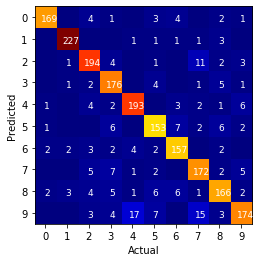

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

# change it according to num_class in your dataset
NUM_LABELS = 10
test_error, confusions = error_rate(np.asarray(preds), np.asarray(labels))
print("Test error: %.1f%%" % test_error)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation="nearest")

for i , cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = 0.07 * len(str(count))
            plt.text(j - xoff, i + 0.2, int(count), fontsize=9, color="white")

### Delete Endpoint
Once you are done using the endpoint, you can use the following to delete it. 

In [60]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '89d062b3-e2c3-42a4-a3e1-a99aa36c0daa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '89d062b3-e2c3-42a4-a3e1-a99aa36c0daa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 04 Apr 2022 01:55:00 GMT'},
  'RetryAttempts': 0}}